In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [1]:
# ============= Import required packaages ==============
import time
import os
import tensorflow as tf

# Import all custom variables and modules
from custom_classes_defs.setup import *
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   
from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 256
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

from tensorflow.data import Dataset as tf_data
# -------------------------------------------------------

### Data preparation and model configurations

---------------

In [2]:
class SeismicData():
    """
    Loading, scaling and preprocessing of the seismic data:
    Returns: tf-datasets
    """
    def __init__(self,
            input_img_paths,
            target_img_paths,
            img_size=(96, 96),
            batch_size=10
        ):
        #super().__init__()
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_size = img_size
        self.batch_size = batch_size
    
    def load_img_masks(self,path):
        data = []
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            if file_name.endswith('.npy'):
                numpy_array = np.load(file_path)
                print(f"Array loaded from '{file_name}' has shape: {numpy_array.shape}")
                data.append(numpy_array)
        print(f"\nThe concatenated array has shape: {np.shape(data)}")
        return np.array(data)

    def get_dataset(self):
        """Returns a TF Dataset."""
        x_train =self.load_img_masks(self.input_img_paths)
        y_train = self.load_img_masks(self.target_img_paths)
        dataset = tf_data.from_tensor_slices((x_train, y_train))
        #dataset = dataset.prefetch(num_parallel_calls=tf_data.AUTOTUNE)
        return dataset.batch(self.batch_size)
    

In [3]:
seis_data_path = 'data_preprocessing/processed_data_temp/seis_train/'
fault_data_path = 'data_preprocessing/processed_data_temp/fault_train/'

seis_val_path = 'data_preprocessing/processed_data_temp/seis_val/'
fault_val_path = 'data_preprocessing/processed_data_temp/fault_val/'

train_data = SeismicData(seis_data_path,fault_data_path)
validation_data = SeismicData(seis_val_path,fault_val_path)

train_dataset = train_data.get_dataset()
val_dataset = validation_data.get_dataset()

Array loaded from '0.npy' has shape: (96, 96)
Array loaded from '1.npy' has shape: (96, 96)
Array loaded from '10.npy' has shape: (96, 96)
Array loaded from '100.npy' has shape: (96, 96)
Array loaded from '11.npy' has shape: (96, 96)
Array loaded from '12.npy' has shape: (96, 96)
Array loaded from '13.npy' has shape: (96, 96)
Array loaded from '14.npy' has shape: (96, 96)
Array loaded from '15.npy' has shape: (96, 96)
Array loaded from '16.npy' has shape: (96, 96)
Array loaded from '17.npy' has shape: (96, 96)
Array loaded from '18.npy' has shape: (96, 96)
Array loaded from '19.npy' has shape: (96, 96)
Array loaded from '2.npy' has shape: (96, 96)
Array loaded from '20.npy' has shape: (96, 96)
Array loaded from '21.npy' has shape: (96, 96)
Array loaded from '22.npy' has shape: (96, 96)
Array loaded from '23.npy' has shape: (96, 96)
Array loaded from '24.npy' has shape: (96, 96)
Array loaded from '25.npy' has shape: (96, 96)
Array loaded from '26.npy' has shape: (96, 96)
Array loaded fr

In [4]:
seis_test_path = 'data_preprocessing/processed_data_temp/seis_test'
fault_test_path = 'data_preprocessing/processed_data_temp/fault_test/'

test_data = SeismicData(seis_test_path,fault_test_path)
test_seismic = test_data.load_img_masks(seis_test_path)

test_label = test_data.load_img_masks(fault_test_path)
np.shape(test_label)

Array loaded from '0.npy' has shape: (96, 96)
Array loaded from '1.npy' has shape: (96, 96)
Array loaded from '10.npy' has shape: (96, 96)
Array loaded from '100.npy' has shape: (96, 96)
Array loaded from '101.npy' has shape: (96, 96)
Array loaded from '102.npy' has shape: (96, 96)
Array loaded from '103.npy' has shape: (96, 96)
Array loaded from '104.npy' has shape: (96, 96)
Array loaded from '105.npy' has shape: (96, 96)
Array loaded from '106.npy' has shape: (96, 96)
Array loaded from '107.npy' has shape: (96, 96)
Array loaded from '108.npy' has shape: (96, 96)
Array loaded from '109.npy' has shape: (96, 96)
Array loaded from '11.npy' has shape: (96, 96)
Array loaded from '110.npy' has shape: (96, 96)
Array loaded from '111.npy' has shape: (96, 96)
Array loaded from '112.npy' has shape: (96, 96)
Array loaded from '113.npy' has shape: (96, 96)
Array loaded from '114.npy' has shape: (96, 96)
Array loaded from '115.npy' has shape: (96, 96)
Array loaded from '116.npy' has shape: (96, 96

(151, 96, 96)

In [12]:

# Model configurations
conf = model_config(
    epochs=50,
    #batch_size=BATCH_SIZE,
    batch_size=10,
    shuffle=True,
    scaling=1,
    img_shape=(96,96), 
    target_size=(96,96), 
    verbose=1,
    save_path='./data_preprocessing/processed_data_temp/output_temp/',
    augmentation=True
)


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

conf.set( validation_data=val_dataset,  callbacks=[es_callback] )
conf.set('compile')
conf.info()

        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
       training_args:
                        epochs: 50
                    batch_size: 10
                       shuffle: True
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <class 'list'>
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: True
new_training_session: False
           save_path: ./data_preprocessing/processed_data_temp/output_temp/
           threshold: 0.5
           pos_label: 1


In [13]:
### Interactive step:
if INTERACTIVE_SESSION:
    train = input("New train session? (y/n): ")
    if train[0].lower()=='y':
        conf.new_training_session = True
    else:
        conf.new_training_session = False
    interact = input("Are you sure, you want to run this session interactively? (y/n): ")
    if interact[0].lower()!='y':
        INTERACTIVE_SESSION = False

### Build  model 

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))
m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
#m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)

model = m_obj.build_model()
model.summary()
#keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
print(f"Total trainable wieghts: {model.count_params():,}")




	Build model
-------------------------------------------------------


Model: "F-NET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 96, 96, 1) │          0 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 48, 48,    │        320 │ sequential[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 48, 48,    │          0 │ activation_51[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_24 │ (None, 48, 48,    │      2,400 │ activation_52[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_53       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_25 │ (None, 48, 48,    │      4,736 │ activation_53[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 24, 24,    │      2,112 │ activation_51[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding_block_1A   │ (None, 24, 24,    │          0 │ max_pooling2d_12… │
│ (Add)               │ 64)               │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 24, 24,    │          0 │ encoding_block_1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_26 │ (None, 24, 24,    │      8,896 │ activation_54[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ separable_conv2d

 Total params: 8,065,089 (30.77 MB)

 Trainable params: 8,050,817 (30.71 MB)

 Non-trainable params: 14,272 (55.75 KB)

Total trainable wieghts: 8,065,089


### Train and evaluate  model



	Train fnet model
-------------------------------------------------------
Model training...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - loss: 2.0883 - val_loss: 1.8314
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - loss: 1.5790 - val_loss: 1.4559
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - loss: 1.5790 - val_loss: 1.4559
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - loss: 1.5790 - val_loss: 1.4559
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - loss: 1.5805 - val_loss: 1.4559
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 491ms/step - loss: 1.5790 - val_loss: 1.4559
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - loss: 1.5790 - val_loss: 1.4559
training elapsed time: ___ 1.07 minutes___
...training completed!


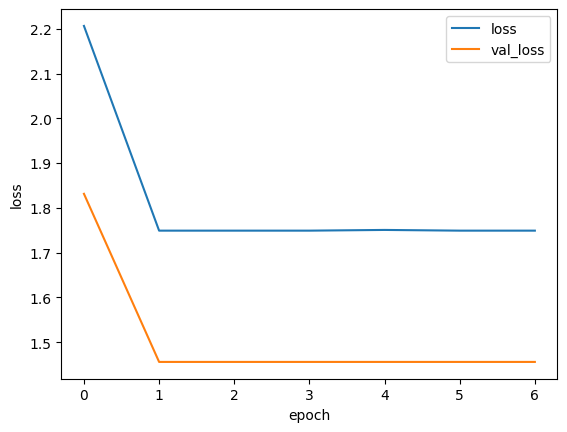

In [15]:

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

conf.execute_training(
    model, 
    data=train_dataset, 
    saveas=m_obj.Name, 
    plot_history=INTERACTIVE_SESSION
)


In [16]:
x_test = np.expand_dims(test_seismic,axis=-1)
y_test = test_label

In [17]:
x_test.shape
y_test.shape

(151, 96, 96)

In [31]:


print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
# fault label probabilities
decoded_imgs = model.predict(x_test)
scores = m_obj.evaluate_sklearn(y_test, decoded_imgs,report=True)
print(scores)



	Evaluate fnet model
-------------------------------------------------------
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step


c:\Users\houji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\houji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\houji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

evaluation elapsed time:___ 0.03___minutes
{'Avg-precision': 0.12, 'f1-score(ODS)': 0.0, 'f1-score(OIS)': 0.0}


c:\Users\houji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\houji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


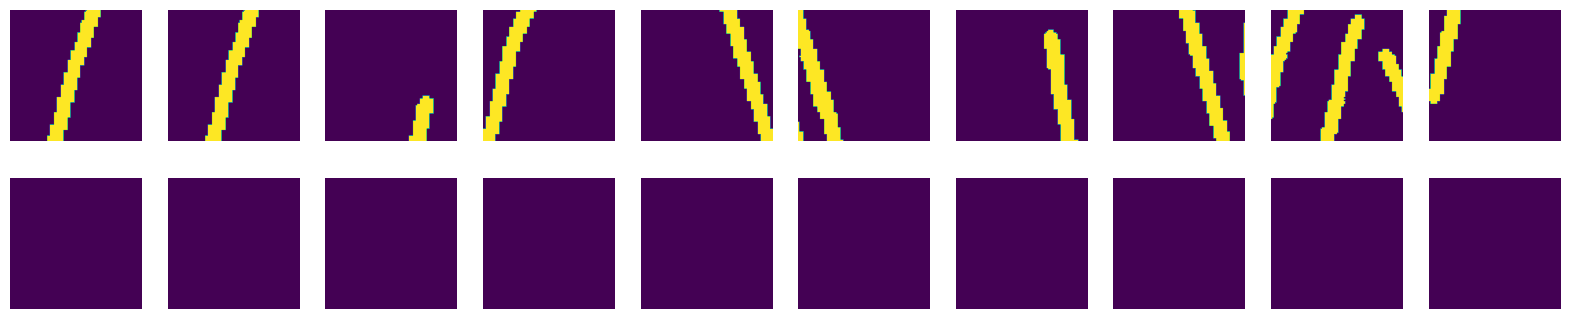

In [44]:
if INTERACTIVE_SESSION:
    #display_sample_images(x_test, decoded_imgs, conf.img_shape)
    display_sample_images(y_test, decoded_imgs, conf.img_shape)

In [45]:
import cv2

def threshold_image(image, threshold_value):
    _, binary_image = cv2.threshold(image, threshold_value, 1, cv2.THRESH_BINARY)
    return binary_image

threshold_label = threshold_image(decoded_imgs,0.5)

In [27]:
decoded_imgs.shape

(151, 96, 96, 1)

In [26]:
threshold_label.shape

(151, 96)